In [1]:
%matplotlib inline

In [2]:
# import libraries 

import pandas as pd

# this is here to shut off some annoying warnings from pandas
pd.options.mode.chained_assignment = None

# matplotlib is one of the main plotting libraries we're going to use
import matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline

# the other plotting library is seaborn - we'll use both during the class

import seaborn as sns

# numpy and scipy are for handling numerical and scientific data

import numpy as np
import scipy as sp

import statsmodels.formula.api as smf # basic statistical modeling

from scipy.stats.stats import pearsonr 

import os

from scipy import stats
from scipy.stats import ks_2samp
from scipy.stats import entropy
from scipy.stats import norm
from scipy.stats import lognorm
from scipy.stats import nbinom
from scipy.stats.mstats import gmean

from pandas.tools.plotting import scatter_matrix



### This lesson analyzes data from the following paper

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4878611/pdf/839.pdf

#### How many biological replicates are needed in an RNA-seq experiment and which differential expression tool should you use?

RNA-seq is now the technology of choice for genome-wide differential gene expression experiments, but it is not clear how many biological replicates are needed to ensure valid biological interpretation of the results or which statistical tools are best for analyzing the data. An RNA-seq experiment with 48 biological replicates in each of two conditions was performed to answer these questions and provide guidelines for experimental design. With three biological replicates, nine of the 11 tools evaluated found only 20%–40% of the significantly differentially expressed (SDE) genes identified with the full set of 42 clean replicates. This rises to >85% for the subset of SDE genes changing in expression by more than fourfold. To achieve >85% for all SDE genes regardless of fold change requires more than 20 biological replicates. The same nine tools successfully control their false discovery rate at ≲5% for all numbers of replicates, while the remaining two tools fail to control their FDR adequately, particularly for low numbers of replicates. For future RNA-seq experiments, these results suggest that at least six biological replicates should be used, rising to at least 12 when it is important to identify SDE genes for all fold changes. If fewer than 12 replicates are used, a superior combination of true positive and false positive performances makes edgeR and DESeq2 the leading tools. For higher replicate numbers, minimizing false positives is more important and DESeq marginally outperforms the other tools.

### Datafiles

There are 96 separate datafiles, each representing the processed output of an RNAseq experiment looking at mRNA levels in wild-type (48 samples) or SNF2 deletion (48 samples) yeast cells grown under standard condition. 

The files are incredible simple. Two columns, separated by tabs. The first column is the gene name, the second column the normalized counts for that gene in that sample (read the paper if you're interested in how they did the counting and normalization).

YBL013W 39
YBL014C 127
YBL015W 732
YBL016W 309
YBL017C 1613
YBL018C 174
YBL019W 117
YBL020W 258
YBL021C 248
YBL022C 1168
YBL023C 331
YBL024W 451
YBL025W 64
YBL026W 206
YBL027W 9723
YBL028C 77
YBL029C-A       157

Most of the genes have this naming format:

Systematic names for nuclear-encoded ORFs begin with the letter 'Y' (for 'Yeast'); the second letter denotes the chromosome number ('A' is chr I, 'B' is chr II, etc.); the third letter is either 'L' or 'R' for left or right chromosome arm; next is a three digit number indicating the order of the ORFs on that arm of a chromosome starting from the centromere, irrespective of strand; finally, there is an additional letter indicating the strand, either 'W' for Watson (the strand with 5' end at the left telomere) or 'C' for Crick (the complement strand, 5' end is at the right telomere).

You can read about the yeast gene naming system here - http://seq.yeastgenome.org/help/community/nomenclature-conventions. 

In [4]:
# load dataframe with expression data

datafile = "data/barton/Barton_combined_Ygenes.txt"
df = pd.read_csv(datafile, sep='\t')   # the sep='\t' tells pandas that it is a tab separated file

df = df.set_index('Gene')

df.head()

,Snf2_rep01,Snf2_rep02,Snf2_rep03,Snf2_rep04,Snf2_rep05,Snf2_rep06,Snf2_rep07,Snf2_rep08,Snf2_rep09,Snf2_rep10,...,WT_rep39,WT_rep40,WT_rep41,WT_rep42,WT_rep43,WT_rep44,WT_rep45,WT_rep46,WT_rep47,WT_rep48
Gene,,,,,,,,,,,,,,,,,,,,,
YAL001C,840,653,823,1036,510,820,1240,549,828,738,...,353,696,492,445,419,289,541,292,647,409
YAL002W,712,530,607,771,395,605,904,351,589,533,...,356,756,552,440,389,291,552,346,622,453
YAL003W,7296,6129,6464,7278,5613,3046,7687,6714,8382,7678,...,9291,12055,13542,8441,7337,8639,14315,6618,14745,9878
YAL004W,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
YAL005C,9851,10226,12006,10714,8575,2791,11764,8237,12213,12446,...,10177,21176,13270,12337,14303,14268,14993,9607,16075,14797


In [5]:
# Now let's look at some data


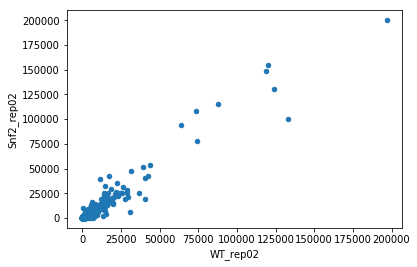

In [6]:

df.plot.scatter(x='WT_rep02',y='Snf2_rep02')

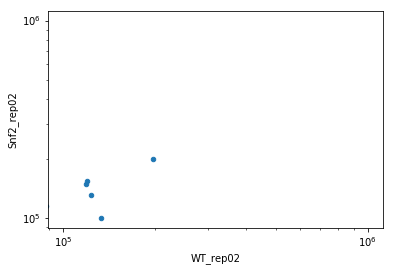

In [7]:
# most of the points are packed in a small range with only a few large values
# most common way to get around this is a log plot


df.plot.scatter(x='WT_rep02',y='Snf2_rep02',logx = True, logy= True)

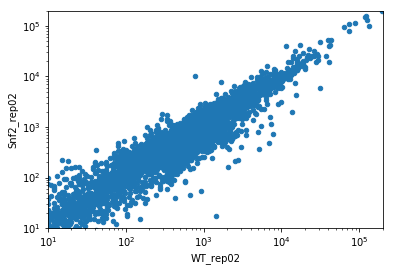

In [8]:
# well that didn't help - now there are values that are too small
# let's set lower and upper bounds for the plot

lower = 10
upper = max(df['WT_rep02'].max(),df['Snf2_rep02'].max())


df.plot.scatter(x='WT_rep02',y='Snf2_rep02',logx = True, logy= True, xlim=(lower,upper), ylim=(lower,upper))

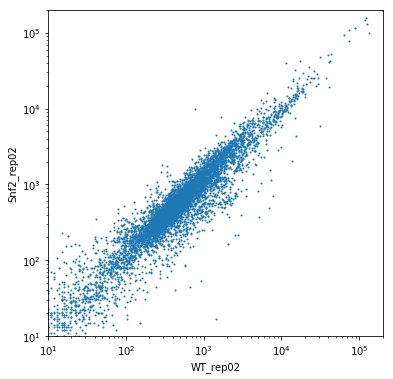

In [9]:
#
# do a few other things to make this pretty
# make points smaller with s=1
# set the figure size to be square
#

df.plot.scatter(x='WT_rep02',y='Snf2_rep02', s=1,logx = True, logy= True, xlim=(lower,upper), ylim=(lower,upper), figsize=(6,6))

In [10]:
# 
# we'd love to do this for all pairs of columns but it's not really practical
#

This quickly gets impossible to look at. So let's try something different. Instead of trying to look at every cell scatterplot, let's summarize each scatterplot with a number, say the correlation coefficient.

In [11]:
# you will likely want to use lists of experiments 

# this comment gets all of the column names and puts them into a list

exps = {}

exps['all'] = [e for e in df.columns.get_values() if e != "Gene"]

# you can then create lists with just WT and Snf2 mutants

# the syntax here in English is 
# [] create a new list
# [e for e in exps] fills the list with all values from the list exps
# if e.startswith('WT') filters the list to only include elements that start with 'WT'



exps['wt'] = [e for e in exps['all'] if e.startswith('WT')] 

exps['mut'] = [e for e in exps['all'] if e.startswith('Snf2')] 

In [12]:
#
# create a matrix to store correlation
#

datalen = len(exps['all'])
corrdata = np.zeros( (datalen,datalen))

for i1,e1 in enumerate(exps['all']):
    for i2,e2 in enumerate(exps['all']):
        corrdata[i1][i2] = pearsonr(df[e1],df[e2])[0] 
      

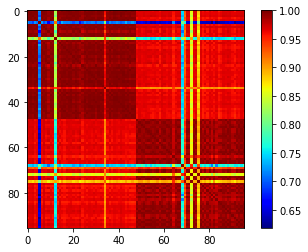

In [13]:
# plot data as a heatmap 
# this option maps every cell in the table into a colored pixel
# the cmap options controls how the mapping is done

plt.imshow(corrdata, cmap='jet')
plt.colorbar()

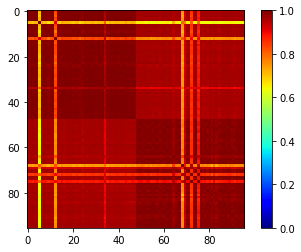

In [14]:
# plot data as a heatmap 
# this option maps every cell in the table into a colored pixel
# the cmap, vmin and vmax options controls how the mapping is done

plt.imshow(corrdata, cmap='jet',vmin=0, vmax=1.0)
plt.colorbar()

Note several things about the data:

1) Most of the correlations are very high -- over .90.
2) There is generally a higher correlation within wts (the upper left quadrant) and muts (the lower right quadrant) than between them (lower left and upper right).
3) There are around 6 experiments that show poor coorelation with the rest of the data and we might want to consider them for exclusion.

We don't want to rely on staring at an image to identify the outliers though, so instead lets calculate for each sample its average correlation with other samples of the same type. 

Text(0.5, 0, 'average within experiment type correlation')

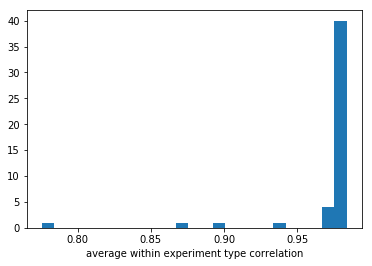

In [15]:
stype = 'wt'

avecorrs = []
for i1,e1 in enumerate(exps[stype]):
    corrs = []
    for i2,e2 in enumerate(exps[stype]):
        if i1 != i2:
            corrs.append(pearsonr(df[e1],df[e2])[0])
    avecorrs.append(np.mean(corrs))

plt.hist(avecorrs,bins=25)
plt.xlabel("average within experiment type correlation")

Text(0.5, 0, 'average within experiment type correlation')

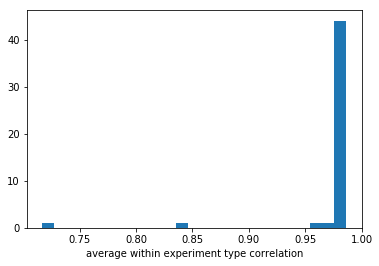

In [16]:
stype = 'mut'

avecorrs = []
for i1,e1 in enumerate(exps[stype]):
    corrs = []
    for i2,e2 in enumerate(exps[stype]):
        if i1 != i2:
            corrs.append(pearsonr(df[e1],df[e2])[0])
    avecorrs.append(np.mean(corrs))

plt.hist(avecorrs, bins=25)
plt.xlabel("average within experiment type correlation")

In both cases it looks like a cutoff of 0.95 seems reasonable. So let's do that. 

In [17]:
exps_filt = {}
exps_filt['all'] = []

corrcutoff = .95 

for stype in ['wt','mut']:
    for i1,e1 in enumerate(exps[stype]):
        corrs = []
        for i2,e2 in enumerate(exps[stype]):
            if i1 != i2:
                corrs.append(pearsonr(df[e1],df[e2])[0])
        if np.mean(corrs) > corrcutoff:
            exps_filt['all'].append(e1)
        
exps_filt['wt'] = [e for e in exps_filt['all'] if e.startswith('WT')] 

exps_filt['mut'] = [e for e in exps_filt['all'] if e.startswith('Snf2')] 

In [18]:
#
# create a matrix to store correlation
#

datalen = len(exps_filt['all'])
corrdata = np.zeros( (datalen,datalen))

for i1,e1 in enumerate(exps_filt['all']):
    for i2,e2 in enumerate(exps_filt['all']):
        corrdata[i1][i2] = pearsonr(df[e1],df[e2])[0] 
      

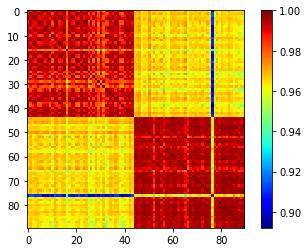

In [19]:
# plot data as a heatmap 
# this option maps every cell in the table into a colored pixel
# the cmap, vmin and vmax options controls how the mapping is done

plt.imshow(corrdata, cmap='jet')
plt.colorbar()

Still one possible outlier, but it's still strongly correlated with other experiments so let's leave it in. You can always revisit this later.

### Question to think about: was this an ok thing to do?

When is/isn't it ok to remove data that looks wonky, and how should you do it?

### Identifying differentially expressed genes

Let's imagine we did an experiment with no replicates - one sample per consdition. 

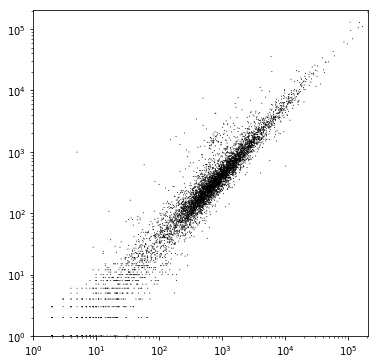

In [20]:
# let's pick a pair of WT and snf2 experiments and see how they compare

c1 = 'Snf2_rep01'
c2 = 'WT_rep01'

x = df[c1]
y = df[c2]

maxval = max(np.max(x),np.max(y))

fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(1,maxval)
ax.set_ylim(1,maxval)

ax.scatter(x, y, s = 1, c='black', edgecolor = 'none')


can already see a problem which is doesn't look like data fall along line y = x 

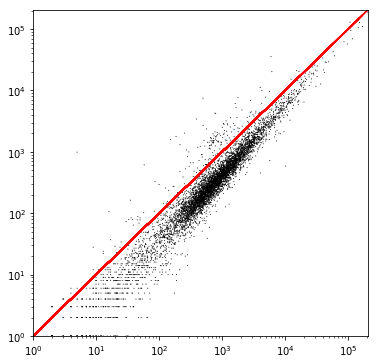

In [21]:
# add the line y = x

c1 = 'Snf2_rep01'
c2 = 'WT_rep01'

# select data, remove really low values

x = df[c1]
y = df[c2]

fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1)
ax.set_xlim(1,maxval)
ax.set_ylim(1,maxval)
ax.set_xscale("log")
ax.set_yscale("log")
ax.scatter(x, y, s = 1, c = 'black', edgecolor = 'none')
ax.plot(x,x,'r-')

Data should fall along line if samples were properly normalized. In principle the method they used to process the data should have corrected this, but it did not. 

There are lots of ways to renormalize the data. I'm going to use one I've always found effective which is to adjust samples so that the median (across all genes) ratio of observed expression over some reference (in this case I use the geometric mean across all experiments) is 1.0.

In [22]:
#
# first calculate geometric mean
#

df['Gmean'] = gmean(df.loc[:,exps['all']],axis=1)

#
# then calculate a normalization factor for each sample
#

colnorm = {}

for c in exps['all']:
    colnorm[c] = np.median((df[c]/df['Gmean']).replace([np.inf, -np.inf], np.nan).dropna())


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:305: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(np.array(a, dtype=dtype))


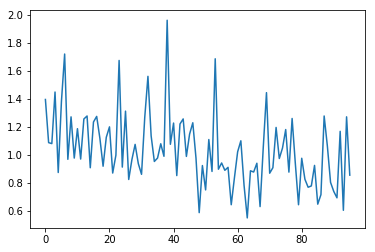

In [23]:
plt.plot([x for x in colnorm.values()])

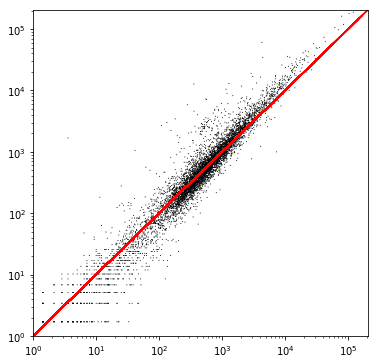

In [24]:
# replot normalized data

c1 = 'Snf2_rep01'
c2 = 'WT_rep01'

# select data, remove really low values

x = df[c1]
y = df[c2]

fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1)
ax.set_xlim(1,maxval)
ax.set_ylim(1,maxval)
ax.set_xscale("log")
ax.set_yscale("log")
ax.scatter(x/colnorm[c1], y/colnorm[c2], s = 1, c = 'black', edgecolor = 'none')
ax.plot(x,x,'r-')

Not perfect, but it's not bad. So let's normalize our columns using these values.

In [27]:
#
# I recalculate these factors here to avoid applying the same normalization factor multiple times
# which would be bad
#

df['Gmean'] = gmean(df.loc[:,exps['all']],axis=1)

#
# then calculate a normalization factor for each sample
#

for c in exps['all']:
    colnorm = np.median((df[c]/df['Gmean']).replace([np.inf, -np.inf], np.nan).dropna())
    df[c] = df[c] / colnorm


So now, how do we identify outliers? Many people start by saying genes up or down 2x. So let's look at those.

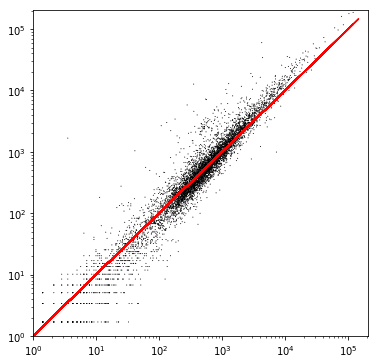

In [28]:
c1 = 'Snf2_rep01'
c2 = 'WT_rep01'

x = df[c1]
y = df[c2]

fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1)
ax.set_xlim(1,maxval)
ax.set_ylim(1,maxval)
ax.set_xscale("log")
ax.set_yscale("log")
ax.scatter(x, y, s = 1, c = 'black', edgecolor = 'none')
ax.plot(x,x,'r-')

OK, now we can begin to look for differentially expressed genes.

In [42]:
# lets make a function to plot differentially expressed genes

def plot_de(df,c1,c2):
    
    fig = plt.figure(figsize = (4,4))
    ax = fig.add_subplot(1,1,1)
    maxval = np.max(np.append(df[c1].values,df[c1].values))
    ax.set_xlim(1,maxval)
    ax.set_ylim(1,maxval)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("WT")
    ax.set_ylabel("Mutant")

    ldf = df[(df[c1] > 1) & (df[c2] > 1) & (df[c1]/df[c2] > 2.0)][[c1,c2]] 
    ax.scatter(ldf[c1],ldf[c2],s=1,c='green',label='down 2x (n = %d)' % len(ldf))

    ldf = df[(df[c1] > 1) & (df[c2] > 1) & (df[c2]/df[c1] > 2.0)][[c1,c2]] 
    ax.scatter(ldf[c1],ldf[c2],s=1,c='red',label='up 2x (n = %d)' % len(ldf))

    plt.legend()

    ldf = df[(df[c1] > 1) & (df[c2] > 1) & (df[c2]/df[c1] < 2.0) & (df[c1]/df[c2] < 2.0)][[c1,c2]] 
    ax.scatter(ldf[c1],ldf[c2],s=1,c='black',alpha = .25)

    ax.plot(x,x,'b-')


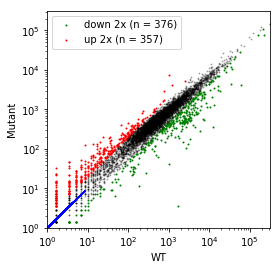

In [44]:
plot_de(df,'WT_rep01','Snf2_rep01')

Text(0, 0.5, 'log(fold change) experiment 2')

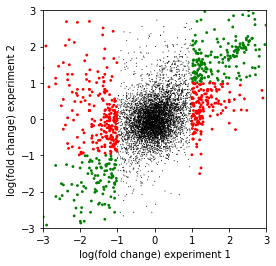

In [45]:
# Does this replicate?

wt1 = 'WT_rep01'
wt2 = 'WT_rep02'

mut1 = 'Snf2_rep01'
mut2 = 'Snf2_rep02'

cols = [wt1,wt2,mut1,mut2]

# create a temporary data frame where any row with values < 1 are removed

tdf = df[cols][df > 1].dropna()

x = np.log2(tdf[wt1]/tdf[mut1]).values
y = np.log2(tdf[wt2]/tdf[mut2]).values

c = []
s = []

for i,vx in enumerate(x):    
    if x[i] > 1.0: 
        if y[i] > 1.0:
            c.append('g')
            s.append(8)
        else:
            c.append('r')
            s.append(8)
    elif x[i] < -1.0:
        if y[i] < -1.0:
            c.append('g')
            s.append(8)
        else:
            c.append('r')
            s.append(8)
    else:
        c.append('k')
        s.append(1)

fig = plt.figure(figsize = (4,4))
ax = fig.add_subplot(1,1,1)
ax.set_xlim(-3,3)
ax.set_ylim(-3,3)
ax.scatter(x, y, s = s, c = c, edgecolor = 'none')
ax.set_xlabel("log(fold change) experiment 1")
ax.set_ylabel("log(fold change) experiment 2")
#ax.plot(x,x,'r-')

Clearly we need more than just one or two samples to accurately identify reproducible differences between samples. But how many do we need?

In [35]:
# first create new columns that are averages

df['ave_wt'] = df[exps_filt['wt']].mean(axis=1)
df['ave_mut'] = df[exps_filt['mut']].mean(axis=1)
df['ave'] = df[exps_filt['wt'] + exps_filt['mut']].mean(axis=1)

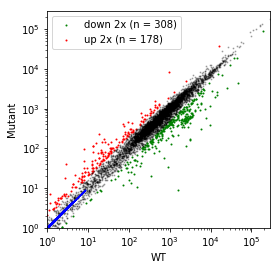

In [46]:
plot_de(df,'ave_wt','ave_mut')

In [48]:
# medians

df['med_wt'] = df[exps_filt['wt']].median(axis=1)
df['med_mut'] = df[exps_filt['mut']].median(axis=1)
df['med'] = df[exps_filt['wt'] + exps_filt['mut']].median(axis=1)

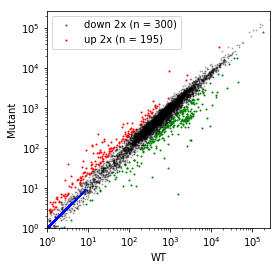

In [49]:
plot_de(df,'med_wt','med_mut')

Does seem like there's a lot of variation to work with here, even averaging out over 40+ experiments, which is good. But means may not be the best measure. What about medians? 

### Looking at individual genes

Now we are going to start looking at individual genes. The first thing we're doing to do is sort based on the magnitude of the ratio between the WT and Snf2 averages and then plot the individual values.

In [53]:
cols = ['ave_wt','ave_mut']

tdf = df[cols][df[cols].max(axis=1) > 10].dropna()


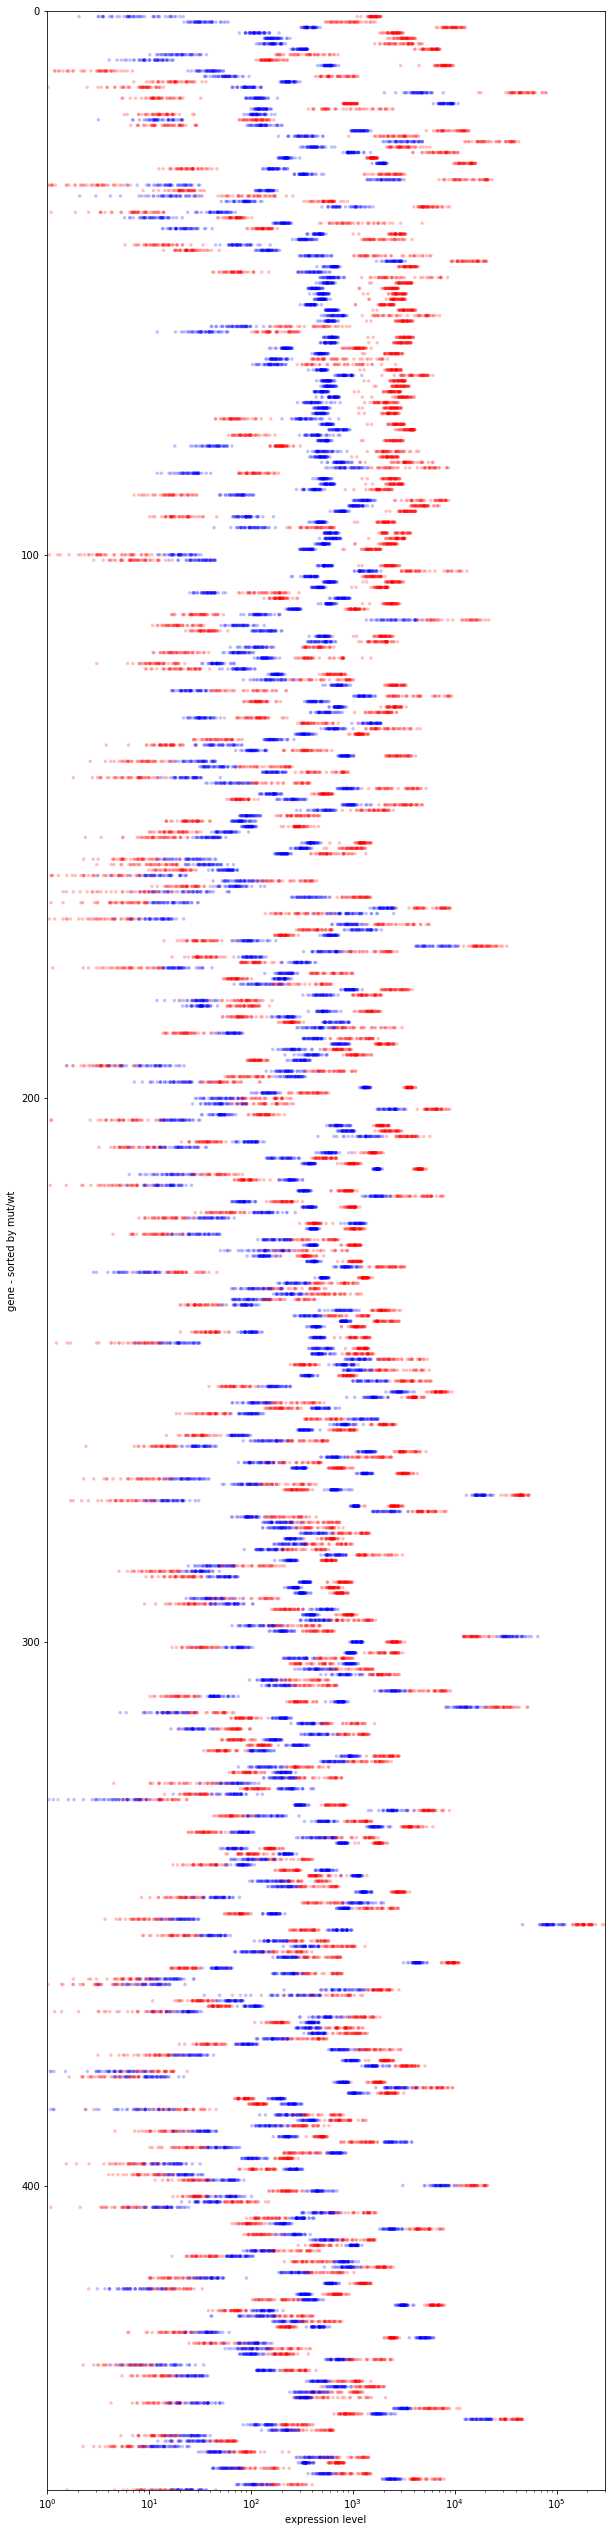

In [57]:
# Sort based ratio of snf2 ave vs wt ave

aved = {}

cols = ['ave_wt','ave_mut']

tdf = df[cols][df[cols].max(axis=1) > 10].dropna()

for index, row in tdf.iterrows():
    mut = row['ave_mut']
    wt = row['ave_wt']
    aved[index] = abs(np.log2(mut/wt))
    
aved = {k:v for (k,v) in aved.items() if v > 1.0}

aveds = sorted(aved.keys(),key = lambda x: aved[x], reverse=True)

mut_ind = []
mut = []
wt_ind = [] 
wt = []

for i,t in enumerate(aveds):
    for c in exps_filt['mut']:
        mut_ind.append(i+1)
        mut.append(df.loc[t,c])
    for c in exps_filt['wt']:
        wt_ind.append(i+1)
        wt.append(df.loc[t,c])
        
fig = plt.figure(figsize = (10,.1*max(wt_ind)))
ax = fig.add_subplot(1,1,1)
ax.set_xlim(1,max(wt + mut))
ax.set_ylim(max(wt_ind + mut_ind),0)
ax.set_xscale("log", nonposx='clip')
ax.set_xlabel("expression level")
ax.set_ylabel("gene - sorted by mut/wt")
ax.scatter(wt,wt_ind,s=12,alpha=.25,c='r',edgecolor='none')
ax.scatter(mut,mut_ind,s=12,alpha=.25,c='b',edgecolor='none')

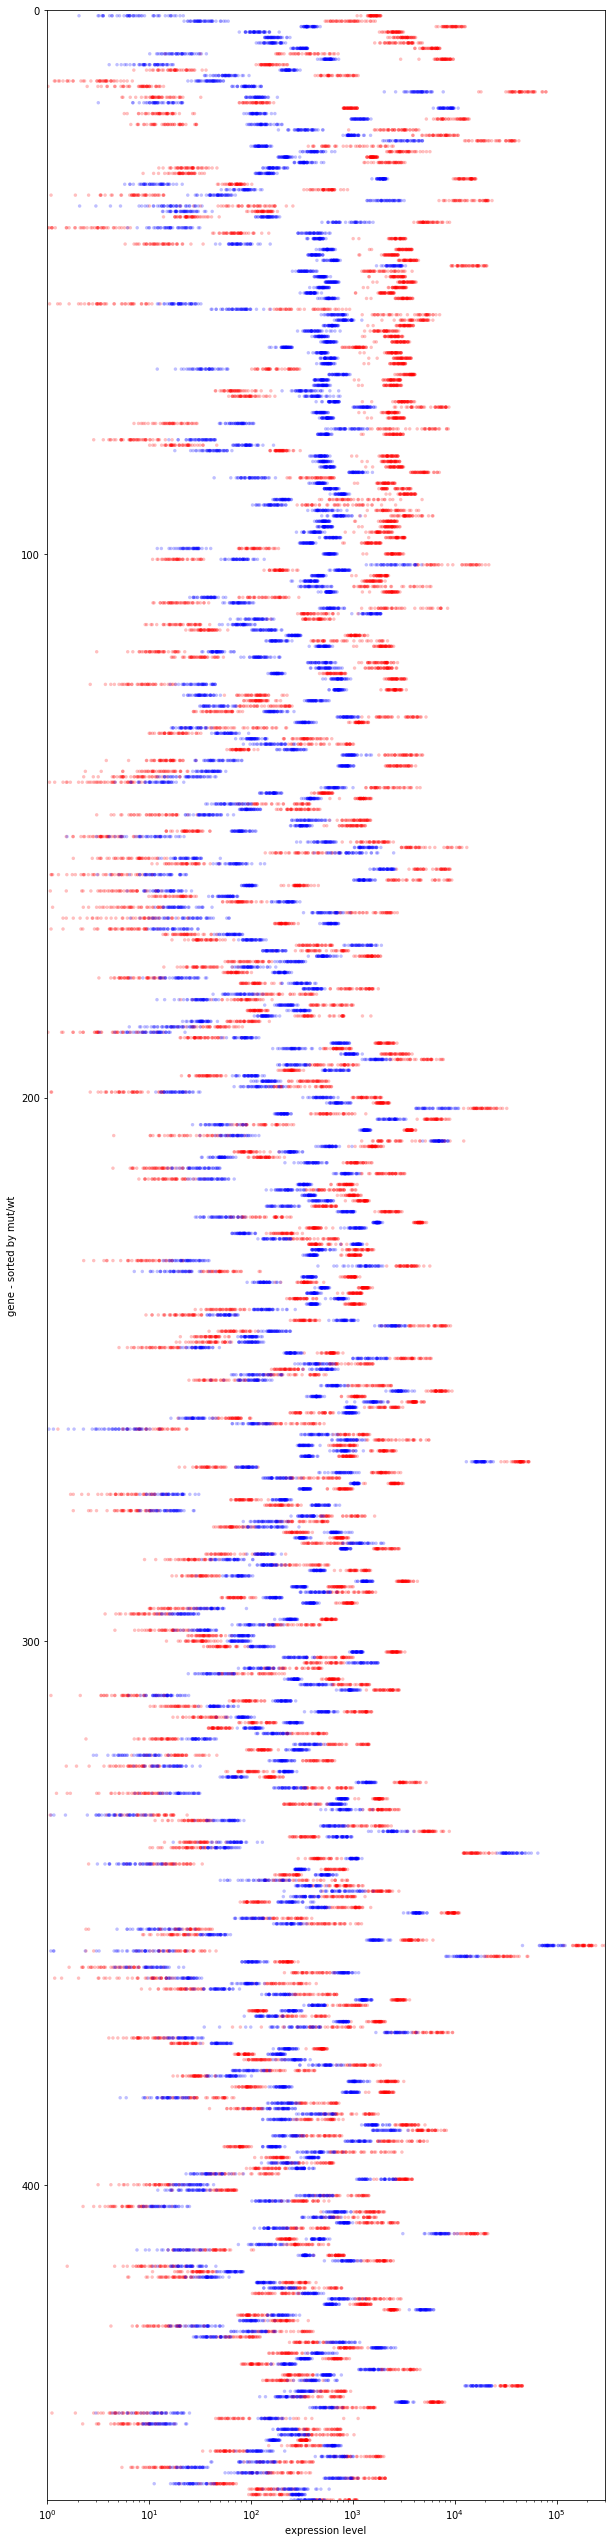

In [61]:
# Sort based ratio of snf2 ave vs wt ave

aved = {}

cols = ['med_wt','med_mut']

tdf = df[cols][df[cols].max(axis=1) > 10].dropna()

for index, row in tdf.iterrows():
    mut = row['med_mut']
    wt = row['med_wt']
    aved[index] = abs(np.log2(mut/wt))
    
aved = {k:v for (k,v) in aved.items() if v > 1.0}

aveds = sorted(aved.keys(),key = lambda x: aved[x], reverse=True)

mut_ind = []
mut = []
wt_ind = [] 
wt = []

for i,t in enumerate(aveds):
    for c in exps_filt['mut']:
        mut_ind.append(i+1)
        mut.append(df.loc[t,c])
    for c in exps_filt['wt']:
        wt_ind.append(i+1)
        wt.append(df.loc[t,c])
        
fig = plt.figure(figsize = (10,.1*max(wt_ind)))
ax = fig.add_subplot(1,1,1)
ax.set_xlim(1,max(wt + mut))
ax.set_ylim(max(wt_ind + mut_ind),0)
ax.set_xscale("log", nonposx='clip')
ax.set_xlabel("expression level")
ax.set_ylabel("gene - sorted by mut/wt")
ax.scatter(wt,wt_ind,s=12,alpha=.25,c='r',edgecolor='none')
ax.scatter(mut,mut_ind,s=12,alpha=.25,c='b',edgecolor='none')

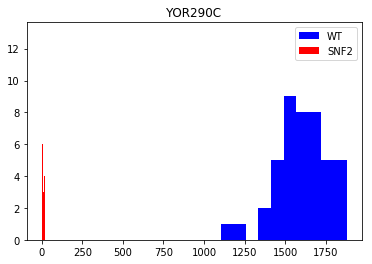

In [66]:
# lets look at individual genes a bit closer

gene = aveds[0]

mut = []
wt = []


for c in exps_filt['mut']:
    mut.append(df.at[gene,c])
for c in exps_filt['wt']:
    wt.append(df.at[gene,c])
        
h = plt.hist(wt, color = 'blue',label='WT')
h = plt.hist(mut, color = 'red',label='SNF2')
plt.title(gene)
plt.legend()

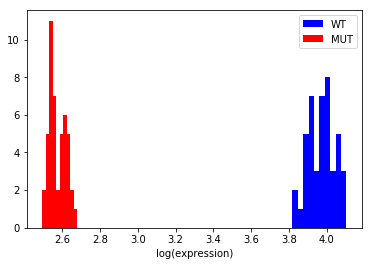

In [69]:
# log transform

gene = aveds[2]

mut = []
wt = []


for c in exps_filt['mut']:
    mut.append(np.log10(df.at[gene,c]))
for c in exps_filt['wt']:
    wt.append(np.log10(df.at[gene,c]))
        
h = plt.hist(wt, color = 'blue',label='WT')
h = plt.hist(mut, color = 'red',label='MUT')
plt.xlabel("log(expression)")
plt.legend()

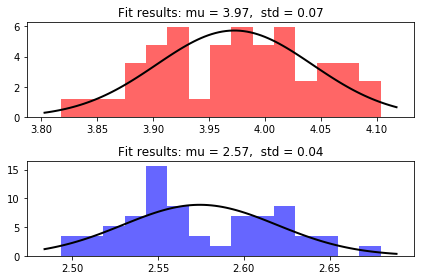

In [70]:
# do the data fit a normal distribution and do we have enough data to do a fit

gene = aveds[2]

mut = []
wt = []

for c in exps_filt['mut']:
    mut.append(np.log10(df.at[gene,c]))
for c in exps_filt['wt']:
    wt.append(np.log10(df.at[gene,c]))


# Fit a normal distribution to the data:
wt_mu, wt_std = norm.fit(wt)
mut_mu, mut_std = norm.fit(mut)

ax = plt.subplot(2, 1, 1)
ax.hist(wt, density=True, bins=15,  alpha=0.6, color='red')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, wt_mu, wt_std)
ax.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (wt_mu, wt_std)
ax.set_title(title)

ax = plt.subplot(2, 1, 2)
ax.hist(mut, bins=15, density=True, alpha=0.6, color='blue')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mut_mu, mut_std)
ax.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mut_mu, mut_std)
ax.set_title(title)
plt.tight_layout()
plt.show()

In [72]:
from scipy.stats import ttest_ind

# compare distributions with t-test

ttest_ind(wt,mut)

Ttest_indResult(statistic=112.35762095147753, pvalue=7.969171779429464e-97)

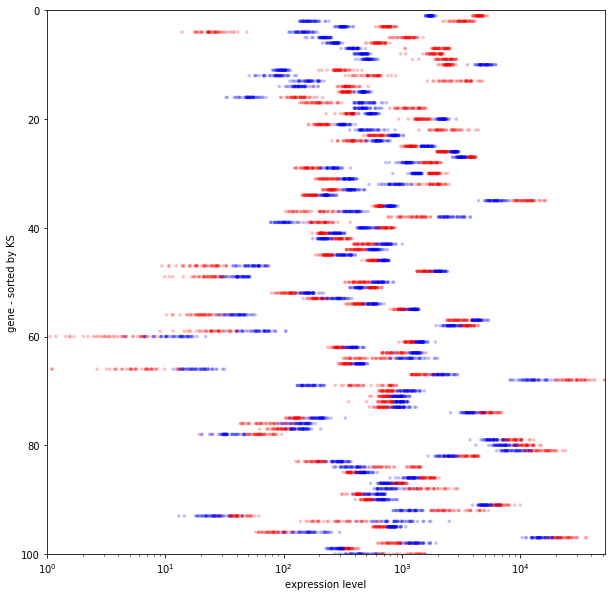

In [75]:
ttestp = {}

for index, row in df.iterrows():
    mut = row[exps_filt['mut']]
    wt = row[exps_filt['wt']]
    ttestp[index] = ttest_ind(wt,mut)[1]
    
ttestps = sorted(ttestp.keys(),key = lambda x: ttestp[x])

mut_ind = []
mut = []
wt_ind = [] 
wt = []

for i,t in enumerate(ttestps[0:100]):
    for c in exps_filt['mut']:
        mut_ind.append(i+1)
        mut.append(df.at[t,c])
    for c in exps_filt['wt']:
        wt_ind.append(i+1)
        wt.append(df.at[t,c])
        
fig = plt.figure(figsize = (10,.1*max(wt_ind)))
ax = fig.add_subplot(1,1,1)
ax.set_xlim(1,max(wt + mut))
ax.set_ylim(max(wt_ind + mut_ind),0)
ax.set_xscale("log", nonposx='clip')
ax.set_xlabel("expression level")
ax.set_ylabel("gene - sorted by KS")
ax.scatter(wt,wt_ind,s=12,alpha=.25,c='r',edgecolor='none')
ax.scatter(mut,mut_ind,s=12,alpha=.25,c='b',edgecolor='none')

Might be better to treat this as a non-parametric test. The test most commonly used to ask if two distributions are different is the Kolmogorov-Smirnov test. https://en.wikipedia.org/wiki/Kolmogorov%E2%80%93Smirnov_test


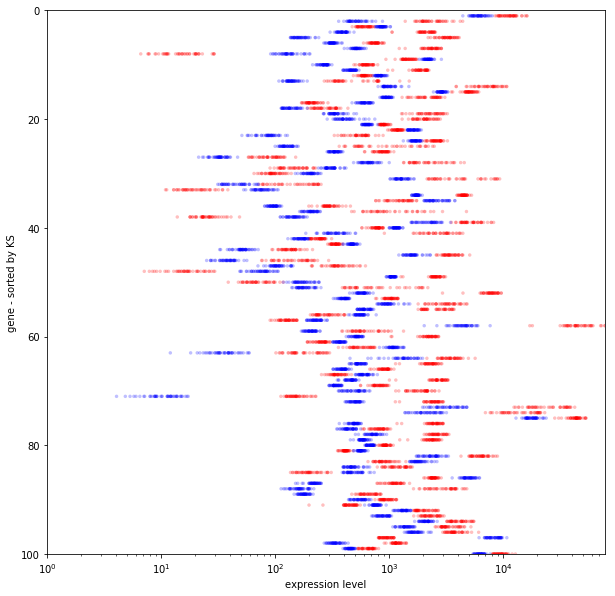

In [76]:
ksv = {}

for index, row in df.iterrows():
    mut = row[exps_filt['mut']]
    wt = row[exps_filt['wt']]
    ksv[index] = ks_2samp(wt,mut)[1]
    
ksvs = sorted(ksv.keys(),key = lambda x: ksv[x])

mut_ind = []
mut = []
wt_ind = [] 
wt = []

for i,t in enumerate(ksvs[0:100]):
    for c in exps_filt['mut']:
        mut_ind.append(i+1)
        mut.append(df.at[t,c])
    for c in exps_filt['wt']:
        wt_ind.append(i+1)
        wt.append(df.at[t,c])
        
fig = plt.figure(figsize = (10,.1*max(wt_ind)))
ax = fig.add_subplot(1,1,1)
ax.set_xlim(1,max(wt + mut))
ax.set_ylim(max(wt_ind + mut_ind),0)
ax.set_xscale("log", nonposx='clip')
ax.set_xlabel("expression level")
ax.set_ylabel("gene - sorted by KS")
ax.scatter(wt,wt_ind,s=12,alpha=.25,c='r',edgecolor='none')
ax.scatter(mut,mut_ind,s=12,alpha=.25,c='b',edgecolor='none')

How does the power of these tests vary as we change the sample size?

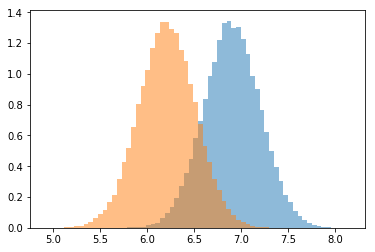

In [114]:
#
# generate some synthetic data
#

replicates = 100000
m1 = 1000
m2 = 500
v = .3

wt = np.random.lognormal(np.log(m1),v,replicates)
mut = np.random.lognormal(np.log(m2),v,replicates)

x = plt.hist(np.log(wt),bins=50,alpha=0.5,density=True)
x = plt.hist(np.log(mut),bins=50,alpha=0.5,density=True)



In [115]:

#
# lets look at the effect of changing the number of experiments we did
#

pvals = {}

trials = 1000

sample_sizes = [2,3,4,5,6,7,8,9,10,15,20]
for n in sample_sizes:
    pvals[n] = []
    for t in range(0,trials):
        wtr = np.random.choice(wt,n)
        mutr = np.random.choice(mut,n)
        #pvals[n].append(-np.log10(ks_2samp(wtr,mutr)[1]))
        pvals[n].append(-np.log10(ttest_ind(wtr,mutr)[1]))
    

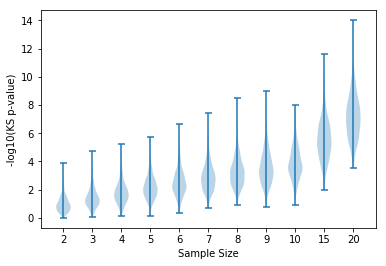

In [116]:
fig, ax = plt.subplots()

ax.violinplot(dataset = [pvals[v] for v in sample_sizes])
ax.set_title('')
ax.yaxis.grid(False)
ax.set_xlabel('Sample Size')
ax.set_ylabel('-log10(KS p-value)')
a = plt.xticks(range(1,len(sample_sizes)+1),sample_sizes)

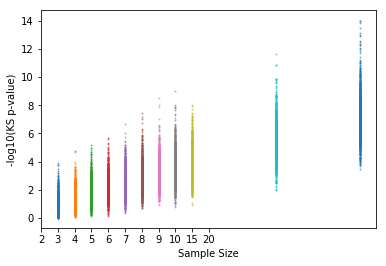

In [118]:
fig, ax = plt.subplots()

for v in sample_sizes:
    ax.scatter([v] * len(pvals[v]),pvals[v], s=1,alpha=.5)

ax.set_title('')
#ax.yaxis.grid(False)
ax.set_xlabel('Sample Size')
ax.set_ylabel('-log10(KS p-value)')
a = plt.xticks(range(1,len(sample_sizes)+1),sample_sizes)